In [1]:
!pip install tensorflow

C:\Users\Parsa\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Epoch 1/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - loss: 0.0321 - val_loss: 0.0014
Epoch 2/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - loss: 0.0012 - val_loss: 0.0015
Epoch 3/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - loss: 8.6538e-04 - val_loss: 8.8961e-04
Epoch 4/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - loss: 7.9743e-04 - val_loss: 9.4857e-04
Epoch 5/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - loss: 6.8689e-04 - val_loss: 8.7173e-04


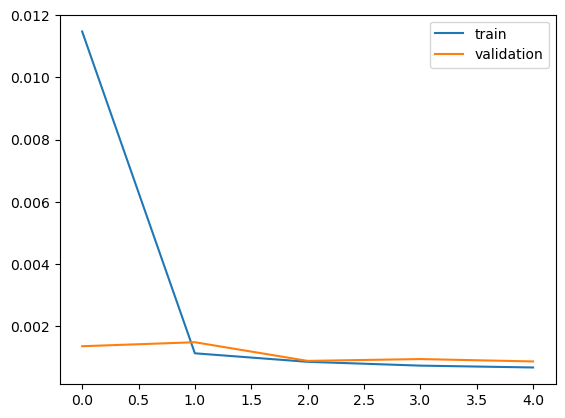

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


# Load the data
data = pd.read_csv('livestock_commodity.csv')

# Convert the Date column to datetime with dayfirst=True
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, format='%d/%m/%y')

# Set the Date column as the index
data.set_index('Date', inplace=True)

# Normalize the LEAN HOGS prices
data['LEAN HOGS'].ffill(inplace = True)
scaler = MinMaxScaler(feature_range=(0, 1))
data['LEAN HOGS'] = scaler.fit_transform(data['LEAN HOGS'].values.reshape(-1, 1))

# Split the data into training and validation sets
train_size = int(len(data) * 0.8)
train_data, val_data = data[:train_size], data[train_size:]

# Function to create sequences for the transformer model
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequence = data[i:i + seq_length]
        target = data[i + seq_length]
        sequences.append((sequence, target))
    return sequences

# Define the sequence length
seq_length = 1000

# Create sequences for training and validation
train_sequences = create_sequences(train_data['LEAN HOGS'].values, seq_length)
val_sequences = create_sequences(val_data['LEAN HOGS'].values, seq_length)

# Convert sequences to numpy arrays
def to_numpy_dataset(sequences):
    seq_array = np.array([seq for seq, target in sequences])
    target_array = np.array([target for seq, target in sequences])
    return seq_array, target_array

train_X, train_y = to_numpy_dataset(train_sequences)
val_X, val_y = to_numpy_dataset(val_sequences)

# Build the transformer model
def transformer_model(seq_length):
    inputs = tf.keras.Input(shape=(seq_length, 1))

    # Transformer block
    x = tf.keras.layers.Conv1D(filters=64, kernel_size=1, padding="causal", activation="relu")(inputs)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(x)

    outputs = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs, outputs)
    return model

model = transformer_model(seq_length)
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(train_X, train_y, epochs=5, batch_size=45, validation_data=(val_X, val_y))

# Plot the training and validation loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

# Forecast the next 24 months
def forecast(model, data, seq_length, steps):
    forecasts = []
    current_sequence = data[-seq_length:]
    for _ in range(steps):
        current_sequence = current_sequence.reshape((1, seq_length, 1))
        next_value = model.predict(current_sequence)
        forecasts.append(next_value[0, 0])
        current_sequence = np.append(current_sequence[:, 1:, :], np.reshape(next_value, (1, 1, 1)), axis=1)
    return forecasts



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

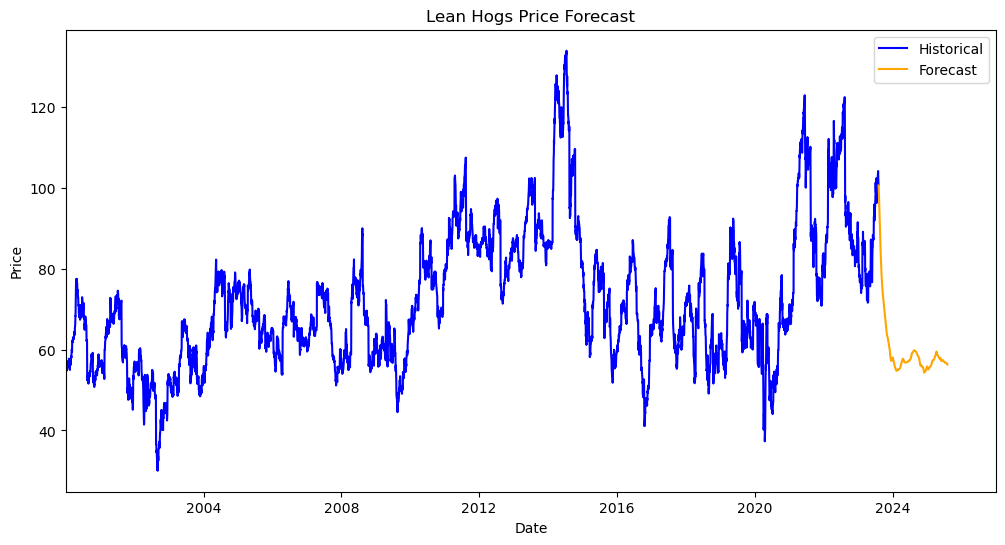

In [6]:
# Forecast the next 2 years
future_steps = 730
future_forecast = forecast(model, data['LEAN HOGS'].values, seq_length, future_steps)


# Inverse transform the forecasted values
future_forecast = scaler.inverse_transform(np.array(future_forecast).reshape(-1, 1))

# Plot the forecast
future_dates = pd.date_range(start=data.index[-1], periods=future_steps + 1, inclusive='right')
plt.figure(figsize=(12, 6))
plt.plot(data.index, scaler.inverse_transform(data['LEAN HOGS'].values.reshape(-1, 1)), label='Historical', color='blue')
plt.plot(future_dates, future_forecast, label='Forecast', color='orange')
plt.title('Lean Hogs Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xlim([data.index[0], pd.Timestamp('2026-12-31')])
plt.show()



In [4]:
future_forecast

array([[100.556984],
       [100.113434],
       [ 99.60903 ],
       [ 99.05168 ],
       [ 98.42615 ],
       [ 97.75638 ],
       [ 97.051025],
       [ 96.31041 ],
       [ 95.52105 ],
       [ 94.70709 ],
       [ 93.870636],
       [ 93.00372 ],
       [ 92.11973 ],
       [ 91.22778 ],
       [ 90.409935],
       [ 89.59734 ],
       [ 88.78501 ],
       [ 87.991974],
       [ 87.220116],
       [ 86.45197 ],
       [ 85.70637 ],
       [ 84.970894],
       [ 84.25777 ],
       [ 83.57033 ],
       [ 82.89355 ],
       [ 82.249   ],
       [ 81.62841 ],
       [ 81.01844 ],
       [ 80.432396],
       [ 79.89248 ],
       [ 79.3588  ],
       [ 78.8449  ],
       [ 78.35288 ],
       [ 77.87813 ],
       [ 77.43826 ],
       [ 77.0105  ],
       [ 76.60349 ],
       [ 76.22363 ],
       [ 75.86321 ],
       [ 75.51884 ],
       [ 75.179695],
       [ 74.85878 ],
       [ 74.55876 ],
       [ 74.2733  ],
       [ 74.00154 ],
       [ 73.743416],
       [ 73.500145],
       [ 73.2